In [1]:
%load_ext autoreload
%autoreload 2

import time

import mujoco as mj
import mujoco.viewer
import mujoco.renderer # Additional import

import numpy as np
from scipy.spatial.transform import Rotation as R

from utility import unit
from controller import Controller
from human import Human

from sensors import Sensors
from video_recorder import Recorder

def move_simple(name, *, t, func, axis=-1, model):
  model.site(name).pos[axis] = func(t)

m = mj.MjModel.from_xml_path('./mjcf/tec.xml')
d = mj.MjData(m)
t = 0

# Create a renderer for data collection
r_rgb = mujoco.renderer.Renderer(m, 480, 640)
r_depth = mujoco.renderer.Renderer(m, 480, 640)
r_seg = mujoco.renderer.Renderer(m, 480, 640)
r_depth.enable_depth_rendering()
r_seg.enable_segmentation_rendering()

# Create a recorder for data collection
sensor = Sensors()
recorder = Recorder(duration=30, 
                    fps=30, 
                    n_cameras=m.cam_user.shape[0], 
                    folder="./")

mujoco.mj_step(m, d)

In [ ]:
with mujoco.viewer.launch_passive(m, d) as viewer:
# Close the viewer automatically after 30 wall-seconds.

    start = time.time()
    while viewer.is_running() and time.time() - start < recorder.duration:
        step_start = time.time()

        # policy
        # mj_step can be replaced with code that also evaluates
        # a policy and applies a contro l signal before stepping the physics.

        move_simple('human1', t=t, func=lambda x: (np.sin(x)+1)/2 * 0.2 + 0.05, axis=-1, model=m)
        move_simple('human2', t=t, func=lambda x: (np.sin(x*2)+1)/2 * 0.2 + 0.05, axis=-1, model=m)
        move_simple('human3', t=t, func=lambda x: (np.sin(x*3)+1)/2 * 0.2 + 0.05, axis=-1, model=m)
        mujoco.mj_step(m, d)
        t += 0.1

        # Get RGB, depth, and segmentation images
        readings = sensor.get_rgbd_seg_matrices(m, d, r_rgb, r_depth, r_seg)
        # Save images to recorder
        recorder.add_frame(readings)

        # Pick up changes to the physics state, apply perturbations, update options from GUI.
        viewer.sync()

        # Rudimentary time keeping, will drift relative to wall clock.
        time_until_next_step = m.opt.timestep - (time.time() - step_start)
        if time_until_next_step > 0:
            time.sleep(time_until_next_step)
            time.sleep(0.01)

# Save videos
# recorder.show_videos()

## Point Cloud Retrieve
Code fragment of how to retrieve the point clouds.

In [13]:
# Retrieve data from the cameras
readings = sensor.get_rgbd_seg_matrices(m, d, r_rgb, r_depth, r_seg)
frames = [readings[i][:, :, 3] for i in range(len(readings))]
segments = [readings[i][:, :, 4] for i in range(len(readings))]

# This can be obtained from the model at the beginning of the simulation
# Or thery can be retrieved at any time during the simulation
# Get the position and rotation of the cameras
poses = []
rotations = []
for i in range(m.cam_user.shape[0]):
    # Get the position of the camera
    pos = m.cam_pos[i] + m.body(m.cam_bodyid[i]).pos
    poses.append(pos)

    # Get the rotation of the camera
    angle = R.from_quat(m.body(m.cam_bodyid[i]).quat).as_euler('xyz', degrees=True)
    rotations.append(angle[0])



# Generate point cloud from depth image
import point_cloud as pcu

point_cloud = pcu.PointCloud((480, 640), 60, downsample=2)

mat = point_cloud.get_map(frames, poses, rotations)

segemented_mat = point_cloud.get_segmented_map(frames, segments, poses, rotations, m)

feature_vectors = point_cloud.get_feature_vectors(segmented_map=segemented_mat)

# Save point cloud
# np.save("point_cloud.npy", mat)

In [14]:
feature_vectors

{'human4': array([0.48709622, 0.00099485, 0.11494577, 0.        ]),
 'human3': array([0.27523576, 0.00828304, 0.07139717, 0.        ]),
 'human1': array([ 0.19275155, -0.2084194 ,  0.06831497,  0.        ]),
 'human2': array([0.19164602, 0.21107623, 0.07347377, 0.        ]),
 'robot4': array([ 0.19068337,  0.60171867,  0.09927401, 40.6       ]),
 'robot2': array([-2.44119197e-02,  2.14477345e-01,  9.70935836e-02,  6.46000000e+01]),
 'robot1': array([-2.37827717e-02, -2.48257831e-02,  1.00724342e-01,  3.67000000e+01]),
 'robot3': array([ 0.18931663, -0.60171867,  0.09927401, 37.3       ])}

In [3]:
size = 0
for key in segemented_mat:
    size += len(segemented_mat[key])

print("Total -> ", mat.shape)
print("Segmented -> ", size)

Total ->  (49929, 3)
Segmented ->  18246


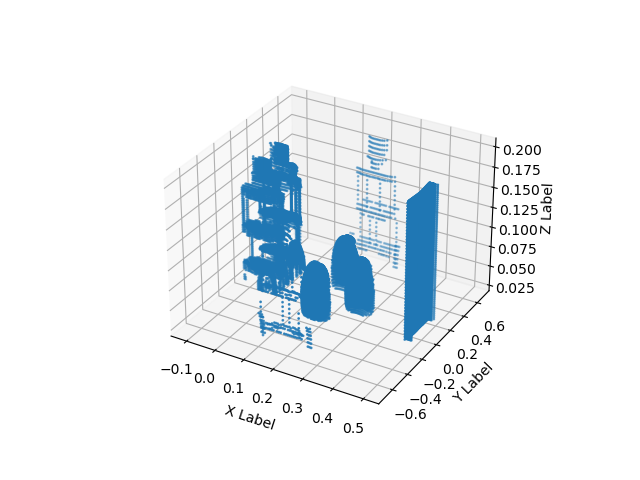

In [4]:
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D figure
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# Define the x, y, z coordinates of the point cloud
x = mat[:, 0]
y = mat[:, 1]
z = mat[:, 2]

# Plot the point cloud data
ax.scatter(x, y, z, s=1)

# Set the axis labels
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

# Show the plot
plt.show()

(25085, 3)


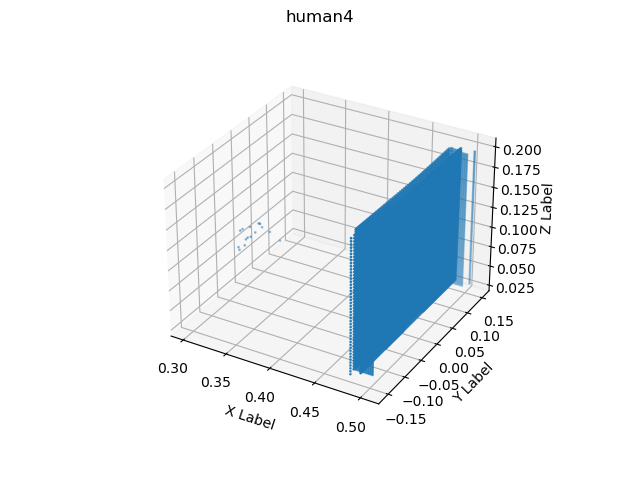

(7159, 3)


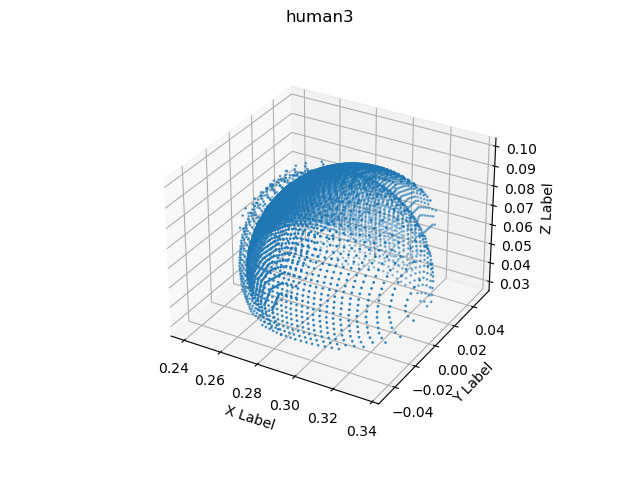

(2835, 3)


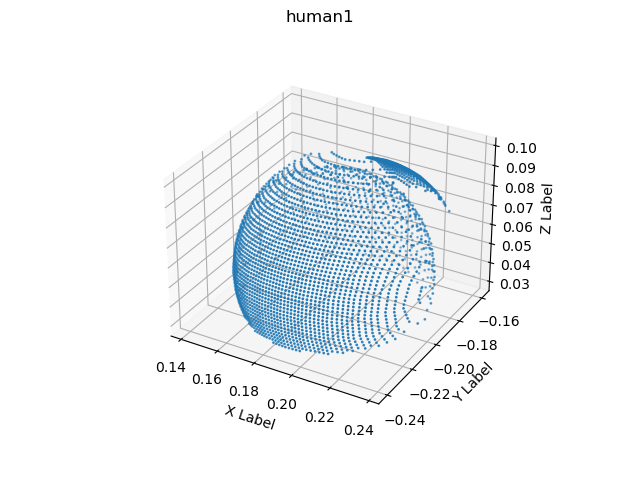

(3354, 3)


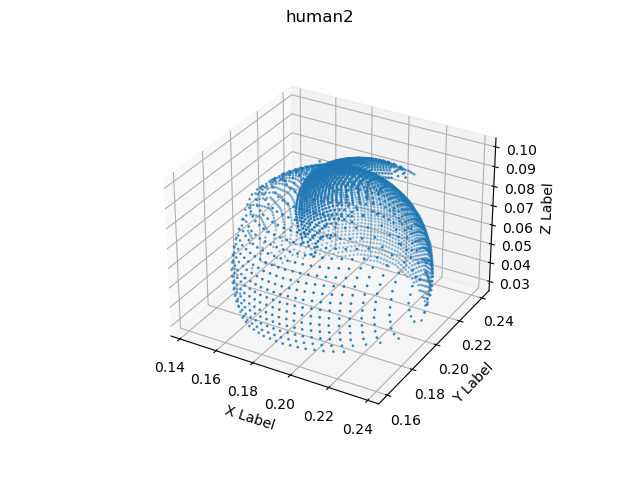

(337, 3)


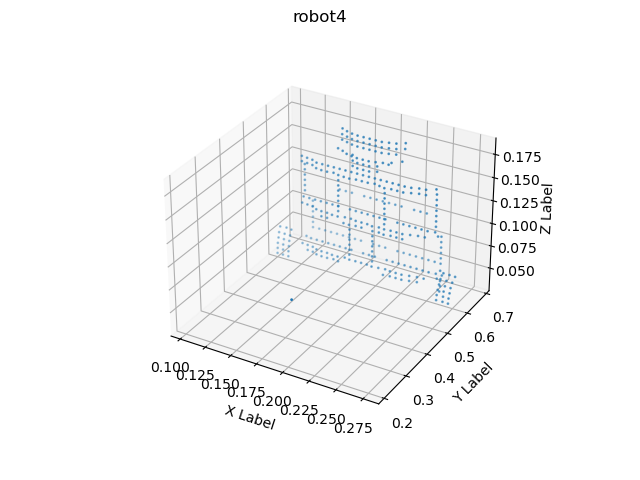

(6719, 3)


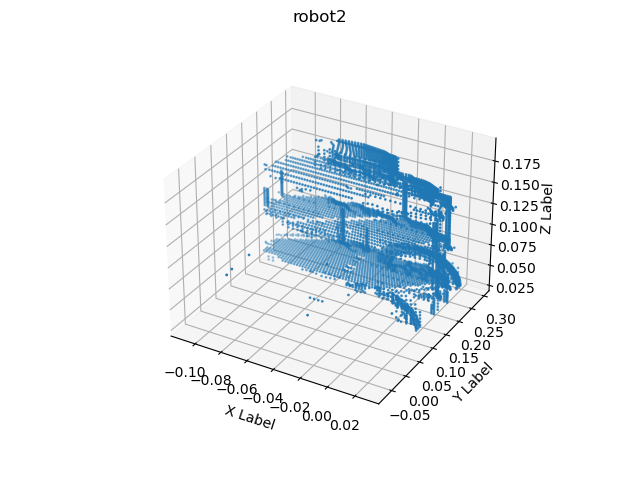

(3836, 3)


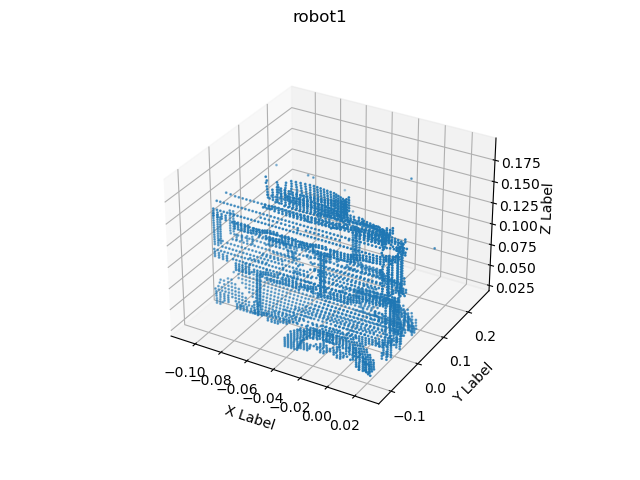

(337, 3)


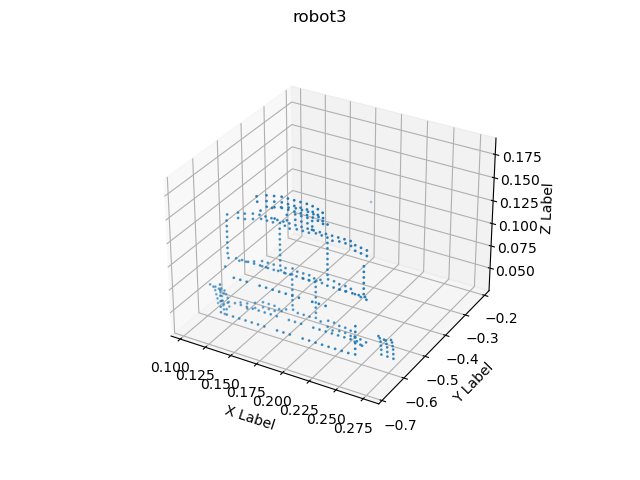

In [10]:
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


for key in segemented_mat.keys():
    mat = np.array(segemented_mat[key])
    print(mat.shape)

    # Create a 3D figure
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    fig.suptitle(key)

    # Define the x, y, z coordinates of the point cloud
    x = mat[:, 0]
    y = mat[:, 1]
    z = mat[:, 2]

    # Plot the point cloud data
    ax.scatter(x, y, z, s=1)

    # Set the axis labels
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')

    # Show the plot
    plt.show()